# Lognormal mocks

Our eventual goal is to compare a direct, harmonic-space analysis of a point set with a more traditional, map-space analysis.  We will do this comparison on mock data. In this notebook, we show how to generate a set of points drawn from a "lognormal catalog" and impose a "survey footprint" covering the quarter of the sky with $|\cos\theta|<1/2$ and $\pi/2 < \phi < 3\pi/2$.

In [1]:
import numpy  as np
import healpy as hp

In [2]:
# Get a random number generator.
seed = 0
rng = np.random.default_rng(seed)

In [3]:
# Code to generate a lognormal catalog of approximately Npnt
# points, assuming a Gaussian angular power spectrum, clg.
def lognormal_catalog(Npnt,clg,nside=256, seed=None):
    """Returns (theta,phi,wt) for about Npnt points.  This
    should be run with Npnt<<Npix=12*nside^2."""
    np.random.seed(seed)
    gmap = hp.synfast(clg,nside,alm=False,pol=False)
    print("gmap in range ({:e},{:e})".format(np.min(gmap),np.max(gmap)))
    emap = np.exp(gmap)
    emap*= Npnt/np.sum(emap)
    print("emap in range ({:e},{:e})".format(np.min(emap),np.max(emap)))
    ngal = rng.poisson(lam=emap,size=emap.size)
    ipix = np.nonzero(ngal>0)[0]
    thta,phi = hp.pix2ang(nside,ipix,lonlat=False)
    wt   = np.ones_like(thta)
    # Now very slightly perturb the positions away from
    # the pixel centers.
    blur = np.sqrt( hp.pixelfunc.nside2pixarea(nside) )
    thta+= blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    phi += blur*rng.uniform(low=-0.5,high=0.5,size=thta.size)
    return( (thta,phi,wt) )

In [4]:
# Generate points -- start with full sky
ell  = np.arange(1000)
ell0 = 10.
clg  = 0.001 * (ell0/(ell+ell0))**(1.1)
nside= 2048
npnt_fullsky = 4 * 100000
thetas,phis,wts = lognormal_catalog(npnt_fullsky,clg,nside,seed)
# and cut to the "observed region"
cost = np.cos(thetas)
ww   = np.nonzero( (np.abs(cost)<0.5)&\
                   (phis>np.pi/2)&(phis<3*np.pi/2) )[0]
thetas,phis,wts = thetas[ww],phis[ww],wts[ww]
#
print("Kept {:d} objects in cut.".format(len(wts)))

gmap in range (-5.505548e+00,5.205058e+00)
emap in range (1.879451e-05,8.425351e-01)
Kept 100018 objects in cut.


In [5]:
# If we wanted to put more structure in the mask
# here we could "cut out" various pieces of the
# disk, vetoing both data and random points.

Let's visualize these maps

In [6]:
def make_map(thetas,phis,wts,nside):
    """Makes a (normalized) Healpix map from the points."""
    pixarea= hp.pixelfunc.nside2pixarea(nside)
    npix   = 12*nside**2
    pixnum = hp.ang2pix(nside,thetas,phis)
    dmap,_ = np.histogram(pixnum,bins=np.arange(npix+1)-0.5,weights=wts)
    dmap   = dmap.astype('float64') / pixarea
    return(dmap)

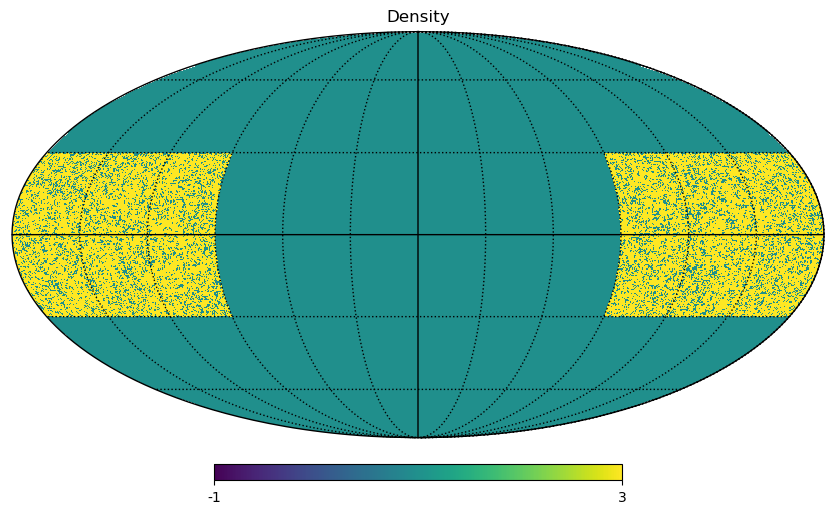

In [7]:
# Show an example at some nside.
# Eventually want to plot in grey the masked region
# and make it look pretty.
nside= 128
dmap = make_map(thetas,phis,wts  ,nside)

hp.mollview(dmap,min=-1,max=3,norm='hist',title='Density')
hp.graticule()

# Packaging

All of this functionality is packaged in the `LogNormalMocks` class in the `mocks` module.  Here is an example of how to use it.

gmap in range (-5.505548e+00,5.205058e+00)
emap in range (1.879451e-05,8.425351e-01)


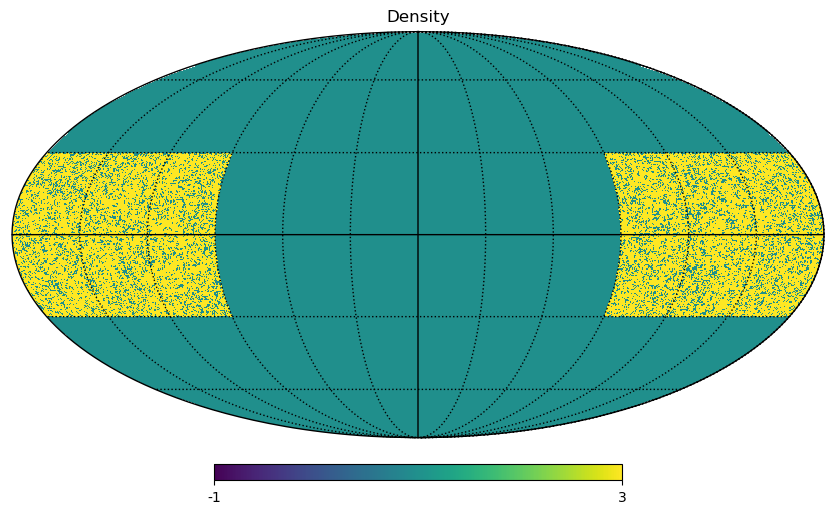

In [8]:
import sys
sys.path.append('../sht')
from  mocks import LogNormalMocks

# Initialize a helper object from which to draw realizations
Mocks_obj = LogNormalMocks(npnt_fullsky, nside=2048,
                           theta_range=[np.arccos(0.5), np.arccos(-0.5)],
                           phi_range=[np.pi/2, 3*np.pi/2])

# Draw a realization, specifying the random seem if you want
t, p, w = Mocks_obj(seed=0)

dmap_v2 = make_map(t,p,w  ,nside)
hp.mollview(dmap_v2,min=-1,max=3,norm='hist',title='Density')
hp.graticule()

This is equivalent to the first approach we presented

In [9]:
np.all(dmap_v2==dmap)

True

But we can easily generate other realizations by playing with the random seed 

gmap in range (-5.157652e+00,5.118487e+00)
emap in range (2.694806e-05,7.823438e-01)


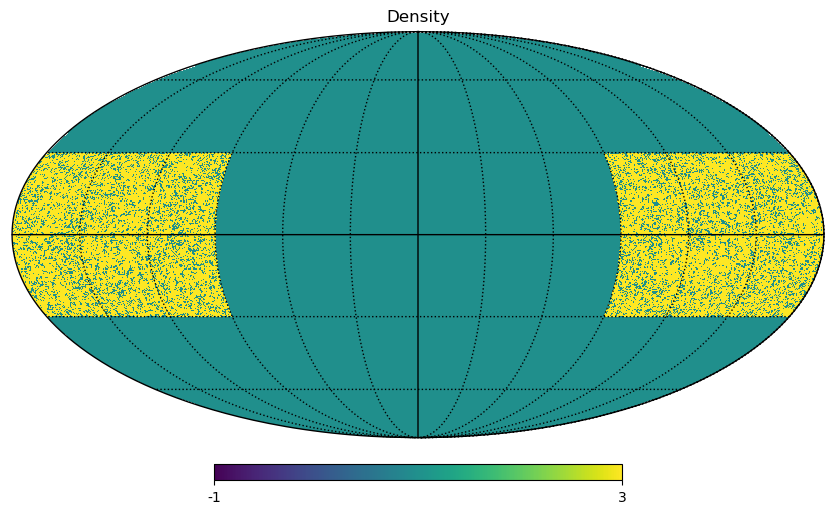

In [10]:
t, p, w = Mocks_obj(seed=4242)

dmap_v2 = make_map(t,p,w  ,nside)
hp.mollview(dmap_v2,min=-1,max=3,norm='hist',title='Density')
hp.graticule()

# The End